In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Scikit-learn nos ofrece una variedad ampliada de modelos Naive Bayes, para este problema usamos MultinomialNB que es pensado para este tipo de problemas
from sklearn.naive_bayes import MultinomialNB   

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# TP3: Detector de SPAM

Uno de los problemas más comunes en la clasificación es la detección de correos electrónicos SPAM. Uno de los primeros modelos utilizados para abordar este problema fue el clasificador de Bayes ingenuo. La detección de SPAM es un problema persistente en el mundo digital, ya que los spammers continúan adaptando sus estrategias para eludir los filtros de correo no deseado. Además del clasificador de Bayes ingenuo, se han desarrollado y utilizado una variedad de técnicas más avanzadas en la detección de SPAM, que incluyen algoritmos de aprendizaje automático, redes neuronales y métodos basados en reglas.

En este trabajo práctico, utilizaremos un conjunto de datos que consta de 4601 observaciones de correos electrónicos, de los cuales 2788 son correos legítimos y 1813 son correos SPAM. Dado que el contenido de los correos electrónicos es un tipo de dato no estructurado, es necesario procesarlo de alguna manera. Para este conjunto de datos, ya se ha aplicado un procesamiento típico en el Procesamiento del Lenguaje Natural (NLP), que consiste en contar la frecuencia de palabras observadas en los correos.

El procesamiento de lenguaje natural (NLP) desempeña un papel fundamental en la detección de SPAM, ya que permite analizar el contenido de los correos electrónicos y extraer características relevantes para la clasificación. Además de contar la frecuencia de palabras, se pueden utilizar técnicas más sofisticadas, como la extracción de características semánticas y el análisis de sentimientos, para mejorar la precisión de los modelos de detección de SPAM.

En este proceso, se cuenta la cantidad de ocurrencias de cada palabra en los diferentes correos.

![spam counter](./spam.png)

Con el fin de preservar la privacidad de los mensajes, la frecuencia de palabras se encuentra normalizada. El conjunto de datos está compuesto por 54 columnas de atributos que se denominan:

- `word_freq_XXXX`: Donde `XXXX` es la palabra o símbolo. Los valores son enteros que van de 0 a 20k.

Además, hay una columna adicional llamada `spam`, que es 1 si el correo es SPAM o 0 si no lo es.

Los clasificadores de Bayes ingenuos fueron los primeros filtros utilizados por las aplicaciones de correo electrónico, basados en este principio de palabras. La idea es que, partiendo de un dato a priori sobre la probabilidad de que un correo sea SPAM o no, ciertas palabras nos indicarán que la probabilidad a posteriori, dadas esas palabras, es más probable que el correo sea SPAM o no.

In [123]:
dataset = pd.read_csv("dataset/spambase.csv") # cargando los datos desde un CSV
display(dataset.head(10))
display(dataset.shape)
display(dataset['spam'].value_counts())


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,spam
0,0,640,640,0,320,0,0,0,0,0,...,0,0,0,0,0,0,778,0,0,1
1,210,280,500,0,140,280,210,70,0,940,...,0,0,0,0,132,0,372,180,48,1
2,60,0,710,0,1230,190,190,120,640,250,...,60,0,0,10,143,0,276,184,10,1
3,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,137,0,137,0,0,1
4,0,0,0,0,630,0,310,630,310,630,...,0,0,0,0,135,0,135,0,0,1
5,0,0,0,0,1850,0,0,1850,0,0,...,0,0,0,0,223,0,0,0,0,1
6,0,0,0,0,1920,0,0,0,0,640,...,0,0,0,0,54,0,164,54,0,1
7,0,0,0,0,1880,0,0,1880,0,0,...,0,0,0,0,206,0,0,0,0,1
8,150,0,460,0,610,0,300,0,920,760,...,0,0,0,0,271,0,181,203,22,1
9,60,120,770,0,190,320,380,0,60,0,...,0,0,0,40,30,0,244,81,0,1


(4601, 55)

spam
0    2788
1    1813
Name: count, dtype: int64

Para obtener las palábras más usadas podemos hacer un `groupby`:

In [124]:
column_sum = dataset.groupby(by="spam", as_index=False).sum()
display(column_sum)

,spam,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#
0,0,204860,681569,559220,2470,504739,124190,26160,107100,106080,...,1159138,800669,22840,142820,140182,442116,63242,306634,32475,60536
1,1,276190,298510,732080,298550,931799,317050,499309,377360,308320,...,226790,26700,2210,3810,37299,197563,14864,931352,316328,143003


Y despues se pueden combinar las columnas en usando [pd.melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html)

In [125]:
# Obtenemos los atributos y target
X = (dataset.drop(columns="spam") * 100).astype(int)
#X = dataset2.drop(columns="spam")
y = dataset["spam"]

In [126]:
no_span_top10 = column_sum.iloc[0].nlargest(10)
display(no_span_top10)
span_top10 = column_sum.iloc[1].nlargest(10)
display(span_top10)
display(pd.concat([no_span_top10, span_top10], axis=1))


word_freq_you        3541702
word_freq_george     3527559
word_freq_hp         2496576
word_freq_will       1495268
word_freq_your       1223098
word_freq_hpl        1204398
word_freq_re         1159138
word_freq_edu         800669
word_freq_address     681569
word_freq_meeting     604460
Name: 0, dtype: int64

word_freq_you         4105599
word_freq_your        2502597
word_freq_will         997100
word_freq_free         939790
word_freq_our          931799
char_freq_!            931352
word_freq_all          732080
word_freq_mail         635470
word_freq_email        578759
word_freq_business     521250
Name: 1, dtype: int64

,0,1
word_freq_you,3541702.0,4105599.0
word_freq_george,3527559.0,NaN
word_freq_hp,2496576.0,NaN
word_freq_will,1495268.0,997100.0
word_freq_your,1223098.0,2502597.0
word_freq_hpl,1204398.0,NaN
word_freq_re,1159138.0,NaN
word_freq_edu,800669.0,NaN
word_freq_address,681569.0,NaN
word_freq_meeting,604460.0,NaN


Se separa el dataset en entrenamiento y evaluación

In [127]:
random_state = 12345 #Repetitibilidad en el train split

In [128]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state=random_state)

Escalamos para aplicar en regresión logística

In [129]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lo transformamos en DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [130]:
bayes_naive = MultinomialNB()
bayes_naive.fit(X_train, y_train)
y_train_pred = bayes_naive.predict(X_train)

print(f"Porcentaje de muestras bien clasificadas: {(bayes_naive.score(X_test, y_test)*100)}%")

Porcentaje de muestras bien clasificadas: 86.82114409847937%


In [131]:
y_test_pred = bayes_naive.predict(X_test)

In [132]:
df_compare = pd.DataFrame({'True Label': y_test, 'Predicted Label': y_test_pred})
df_compare = df_compare[df_compare['True Label'] != df_compare['Predicted Label']]
display(df_compare)
print(f"Cantidad de mal clasificados (0: no_spam | 1: spam): {df_compare['Predicted Label'].value_counts()}")

,True Label,Predicted Label
1722,1,0
4220,0,1
3469,0,1
2051,0,1
4525,0,1
...,...,...
4261,0,1
1556,1,0
2278,0,1
4338,0,1


Cantidad de mal clasificados (0: no_spam | 1: spam): Predicted Label
1    152
0     30
Name: count, dtype: int64


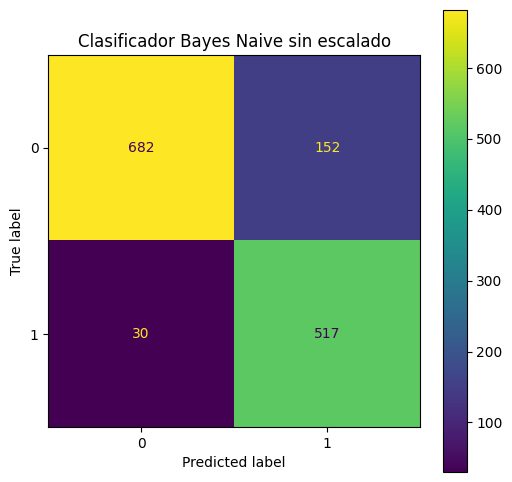

In [133]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Clasificador Bayes Naive sin escalado");

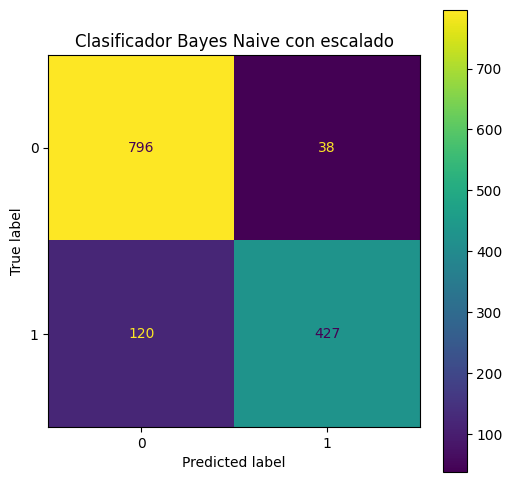

In [134]:
#Si tomo lo escalado para Bayes
bayes_naive.fit(X_train_scaled, y_train)
y_test_pred = bayes_naive.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Clasificador Bayes Naive con escalado");

In [135]:
regresion_logistica = LogisticRegression()
regresion_logistica.fit(X_train_scaled, y_train)
y_test_pred = regresion_logistica.predict(X_test_scaled)

print(f"Porcentaje de muestras bien clasificadas: {(regresion_logistica.score(X_test, y_test)*100)}%")

Porcentaje de muestras bien clasificadas: 80.30412744388124%


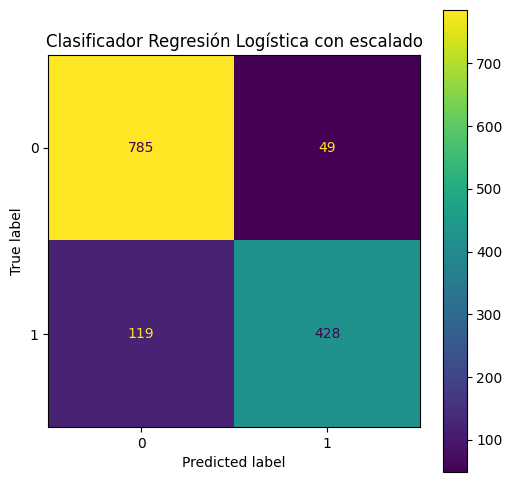

In [137]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(6,6))
ax.grid(False)
disp.plot(ax=ax)
ax.set_title("Clasificador Regresión Logística con escalado");

In [138]:
bayes_naive.fit(X_train, y_train)
y_test_pred_nv = bayes_naive.predict(X_test)
regresion_logistica.fit(X_train_scaled, y_train)
y_test_pred_rl = regresion_logistica.predict(X_test_scaled)

from sklearn.metrics import precision_score, recall_score

print("Modelo Bayes Naive")
print(f"Precision: {precision_score(y_test, y_test_pred_nv, zero_division=0)}")
print(f"Recuperación: {recall_score(y_test, y_test_pred_nv, zero_division=0)}")
print("------------------------------")
print("Modelo Regresión Logística")
print(f"Precision: {precision_score(y_test, y_test_pred_rl, zero_division=0)}")
print(f"Recuperación: {recall_score(y_test, y_test_pred_rl, zero_division=0)}")

Modelo Bayes Naive
Precision: 0.772795216741405
Recuperación: 0.9451553930530164
------------------------------
Modelo Regresión Logística
Precision: 0.8972746331236897
Recuperación: 0.7824497257769653


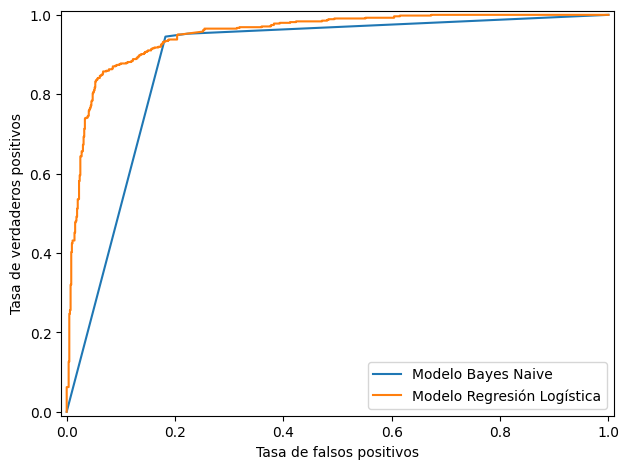

In [139]:
from sklearn.metrics import auc, roc_curve

prob_nv = bayes_naive.predict_proba(X_test)[:, -1]
prob_lv = bayes_naive.predict_proba(X_test_scaled)[:, -1]

fpr_bayes_naive, tpr_bayes_naive, _ = roc_curve(y_test, prob_nv)
fpr_regresion_logistica, tpr_regresion_logistica, _ = roc_curve(y_test, prob_lv)

plt.plot(fpr_bayes_naive, tpr_bayes_naive, label="Modelo Bayes Naive")
plt.plot(fpr_regresion_logistica, tpr_regresion_logistica, label="Modelo Regresión Logística")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()
plt.tight_layout();

In [140]:
print(f"Modelo Bayes Naive AUC: {auc(fpr_bayes_naive, tpr_bayes_naive)}")
print(f"Modelo Regresión Logística AUC: {auc(fpr_regresion_logistica, tpr_regresion_logistica)}")

Modelo Bayes Naive AUC: 0.8833225923831319
Modelo Regresión Logística AUC: 0.9515254341316708
